# RNN

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## PREPROCESSING

In [2]:
class time_series_data():
    def __init__(self,num_points,xmin,xmax):
        self.xmin=xmin
        self.xmax=xmax
        self.num_points=num_points
        self.resolution=(xmax-xmin)/num_points
        self.x_data=np.linspace(xmin,xmax,num_points)
        self.y_true=np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_ts=False):
        rand_start = np.random.rand(batch_size,1)
        ts_start = rand_start * (self.xmax - self.xmin - self.resolution*steps)
        batch_ts = ts_start + np.arange(0.0,steps+1)*self.resolution
        y_batch = np.sin(batch_ts)
        if return_ts:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1) , batch_ts
        else :
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1)

In [3]:
ts_data = time_series_data(250,0,10)

## MODEL

In [4]:
tf.reset_default_graph()

In [5]:
neurons = 100
inputs = 1
outputs = 1
learning_rate = 0.001
training_iterations = 5000
num_time_steps = 30
batch_size = 10

In [6]:
X = tf.placeholder(tf.float32,[None,num_time_steps,inputs])
Y = tf.placeholder(tf.float32,[None ,num_time_steps, outputs])

In [7]:
layer = tf.contrib.rnn.BasicLSTMCell(neurons,activation=tf.nn.relu)
cell_layer = tf.contrib.rnn.OutputProjectionWrapper(layer,output_size=1)

In [8]:
output,states = tf.nn.dynamic_rnn(cell_layer,X,dtype=tf.float32)

In [9]:
mse = tf.reduce_mean(tf.square(output-Y))

In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(mse)

In [11]:
init = tf.global_variables_initializer()

In [12]:
saver = tf.train.Saver()

## TRAINING

In [13]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(training_iterations):
        batch_x,batch_y = ts_data.next_batch(batch_size,num_time_steps)
        sess.run(train,feed_dict={X:batch_x,Y:batch_y})
        if i%100==0:
            loss = mse.eval(feed_dict={X:batch_x,Y:batch_y})
            print('At {} loss {}'.format(i,loss))
    saver.save(sess,'./rnn_time_series_sin')

At 0 loss 0.30919015407562256
At 100 loss 0.02344156987965107
At 200 loss 0.010441867634654045
At 300 loss 0.008679197169840336
At 400 loss 0.003179664723575115
At 500 loss 0.00410083495080471
At 600 loss 0.0023027737624943256
At 700 loss 0.0005272497655823827
At 800 loss 0.00018277311755809933
At 900 loss 0.00010106027184519917
At 1000 loss 0.00010190453758696094
At 1100 loss 8.489743049722165e-05
At 1200 loss 6.375743396347389e-05
At 1300 loss 0.00010453384311404079
At 1400 loss 0.00011826795525848866
At 1500 loss 0.00013905063678976148
At 1600 loss 7.458421896444634e-05
At 1700 loss 7.009646651567891e-05
At 1800 loss 9.067392238648608e-05
At 1900 loss 8.365872054127976e-05
At 2000 loss 3.426771581871435e-05
At 2100 loss 4.3199641368119046e-05
At 2200 loss 9.89873442449607e-05
At 2300 loss 9.641366341384128e-05
At 2400 loss 6.273132748901844e-05
At 2500 loss 6.074050907045603e-05
At 2600 loss 6.906339694978669e-05
At 2700 loss 3.737286169780418e-05
At 2800 loss 5.7592595112510026e-05

## TESTING

In [14]:
with tf.Session() as sess:
    saver.restore(sess,'./rnn_time_series_sin')
    x_=np.linspace(0,3,num_time_steps + 1)
    x_ls=x_[:-1].reshape(1,-1,1)
    x_rs=x_[1:].reshape(1,-1,1)
    y_p = np.sin(x_ls)
    #y_t = np.sin(x_rs)
    y_pred = sess.run(output,feed_dict={X:y_p})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_sin


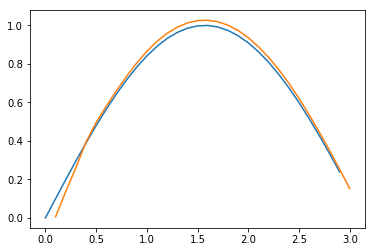

In [15]:
plt.plot(x_ls.flatten(),y_p.flatten())
plt.plot(x_rs.flatten(),y_pred.flatten())

## GENERATING NEW SEQUENCES

In [16]:
with tf.Session() as sess:
    saver.restore(sess,'./rnn_time_series_sin')
    x_g = np.linspace(0,10,200)
    y_g = np.sin(x_g)
    y_list = list(y_g[:num_time_steps])
    for i in range(200-num_time_steps):
        x_batch = np.array(y_list[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(output,feed_dict={X:x_batch})
        y_list.append(y_pred.flatten()[-1])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_sin


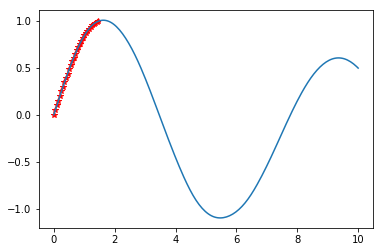

In [17]:
plt.plot(x_g[:num_time_steps],y_g[:num_time_steps],'r*')
plt.plot(x_g,y_list)